In [255]:
import scipy.io
import scipy.signal
import scipy.fft
import matplotlib.pyplot as plt
import numpy as np

In [256]:
#Loading the audio file
signal = scipy.io.wavfile.read('signal.wav')
numSamples = len(signal[1])
print('Sample rate is:', signal[0], 'and the number of signals is:', numSamples)
print('This corresponds to', numSamples/signal[0], 'seconds')

Sample rate is: 16000 and the number of signals is: 18091
This corresponds to 1.1306875 seconds


In [257]:
#Mean subtraction
mean = np.mean(signal[1])
print(mean)
meanSub = signal[1] - mean

11756.525786302582


In [258]:
#Pre-emphasis
b = 0.97 #given constant
np.insert(meanSub, 0, 0)
preEmp = np.array([meanSub[i]-b*meanSub[i-1] for i in range(1, numSamples-1)])
print(preEmp)


[ 279946.55422641 -120352.58577359  -41547.25577359 ...  102152.87422641
 -137258.38577359 -149305.20577359]


In [259]:
#Computing frames
#Window length 𝐿 set to 25 milliseconds: this is (25/1000)/(1/16000) = 400 samples
#Window shift 𝑆 set to 10 milliseconds: this is (16/1000)/(1/16000) = 256 samples
L = 400
S = 256
#dimensions of the return array are ceil(numSamples/S) rows by L samples
frames = []
k = 0
while k*S<len(preEmp):
    frames.append([])
    n = 0
    while  n<L:
        ind = k*S+n
        sample = 0
        if  ind<len(preEmp):
            sample = preEmp[ind]
        frames[k].append(sample)
        n+=1
    k+=1
frames = np.array(frames)
print(frames[0])

[ 2.79946554e+05 -1.20352586e+05 -4.15472558e+04  1.04226374e+05
  1.19977824e+05 -3.60713577e+03 -3.58461658e+04 -6.56787058e+04
  3.31329842e+04  1.69963754e+05 -2.62498458e+04  3.41063442e+04
 -8.48566758e+04  1.07346084e+05 -1.25597858e+04 -7.86952058e+04
  1.20609444e+05 -7.79198358e+04  1.65913074e+05 -4.25543158e+04
  1.49140054e+05  2.61628342e+04 -4.17082258e+04  1.18135384e+05
 -4.40965958e+04  3.24540842e+04  9.63736542e+04  9.14285642e+04
  9.75637442e+04  3.66441642e+04 -9.46604258e+04  2.02745274e+05
 -4.87749358e+04 -1.06573577e+03  1.13518014e+05  1.08435642e+04
  6.77153442e+04 -5.10374358e+04  4.68868742e+04  2.13449584e+05
  9.13175942e+04 -1.79896256e+05  1.40742564e+05  2.75773442e+04
  6.98606342e+04  9.18058142e+04 -2.33225386e+05  1.09533064e+05
  9.10850142e+04 -5.41484058e+04  1.01392124e+05  5.58212442e+04
  4.84213642e+04 -9.14136577e+03  3.17185442e+04  5.88310742e+04
 -2.51420458e+04  1.13635274e+05  5.47839142e+04  1.45249614e+05
 -8.62078558e+04  1.00167

In [260]:
#Applying window function
window = scipy.signal.hamming(L)
#print(window)
for row in range(len(frames)):
    frames[row]*=window
print(frames[0])


[ 2.23957243e+04 -9.63507104e+03 -3.33325828e+03  8.39160099e+03
  9.70767679e+03 -2.93711534e+02 -2.94124008e+03 -5.43766408e+03
  2.77142231e+03  1.43809920e+04 -2.24939464e+03  2.96329566e+03
 -7.48339445e+03  9.61877881e+03 -1.14461930e+03 -7.30081614e+03
  1.14004741e+04 -7.51029736e+03  1.63185394e+04 -4.27400693e+03
  1.53056562e+04  2.74511102e+03 -4.47654238e+03  1.29763628e+04
 -4.95923563e+03  3.73834946e+03  1.13740272e+04  1.10588281e+04
  1.20974854e+04  4.65888879e+03 -1.23421983e+04  2.71132887e+04
 -6.69086883e+03 -1.49976660e+02  1.63888738e+04  1.60611698e+03
  1.02899473e+04 -7.95657770e+03  7.49862548e+03  3.50180438e+04
  1.53667807e+04 -3.10485359e+04  2.49107816e+04  5.00499584e+03
  1.29991323e+04  1.75113215e+04 -4.55956489e+04  2.19441946e+04
  1.86970276e+04 -1.13863291e+04  2.18370018e+04  1.23110408e+04
  1.09333239e+04 -2.11279647e+03  7.50241167e+03  1.42378245e+04
 -6.22434275e+03  2.87718482e+04  1.41831953e+04  3.84420344e+04
 -2.33191032e+04  2.76863

In [261]:
#Computing the Fourier transform
N = 512 #number of DFT points, given
fourier = scipy.fft.fft(frames, N)
print(fourier)


[[ 2.83087248e+06      -0.j         -5.58968070e+05 -967207.34636698j
   9.01472616e+04 -771976.08684657j ... -6.05383316e+05 +267144.64227308j
   9.01472616e+04 +771976.08684657j -5.58968070e+05 +967207.34636698j]
 [ 9.12286472e+05      -0.j          8.69613556e+04 -630378.90058358j
   5.06968590e+04  -74143.08971839j ... -9.12234013e+05+1106310.33311423j
   5.06968590e+04  +74143.08971839j  8.69613556e+04 +630378.90058358j]
 [-1.92830776e+06      -0.j          1.82675182e+06  +95124.29878402j
  -1.28268232e+06 -462902.23930823j ... -1.23250285e+04  -40137.96665517j
  -1.28268232e+06 +462902.23930823j  1.82675182e+06  -95124.29878402j]
 ...
 [-2.26442247e+06      -0.j         -1.43793602e+05+5575864.01106215j
   8.93353042e+06-3975385.2911357j  ... -6.96301021e+06+7470965.3518971j
   8.93353042e+06+3975385.2911357j  -1.43793602e+05-5575864.01106215j]
 [ 1.28759414e+07      -0.j         -9.05468390e+06 -689276.03105839j
   2.60477267e+06-2427254.3303719j  ...  1.10273093e+06-6730610.50

In [262]:
#Computing the magnitude and power spectra
magnitude = np.abs(fourier)
magnitude = np.array(magnitude)
print(magnitude)
power = np.square(magnitude)

[[ 2830872.47675556  1117110.26966869   777221.72347282 ...
    661706.29366842   777221.72347282  1117110.26966869]
 [  912286.47239015   636348.83174843    89818.53521872 ...
   1433908.45181778    89818.53521872   636348.83174843]
 [ 1928307.76294528  1829226.84088088  1363654.06626321 ...
     41987.64930073  1363654.06626321  1829226.84088088]
 ...
 [ 2264422.47102546  5577717.81913027  9778121.18644964 ...
  10212680.08188304  9778121.18644964  5577717.81913027]
 [12875941.40537587  9080881.12565066  3560393.83420065 ...
   6820347.00066803  3560393.83420065  9080881.12565066]
 [ 1793671.44911921  2622315.43373806  3351062.36724393 ...
   2930078.3990888   3351062.36724393  2622315.43373806]]


[[0.         0.         0.00148739 ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]]
[7.79157892e+09 4.43773331e+09 2.53986087e+09 5.78751603e+09
 6.62260267e+09 5.47436550e+09 5.36595192e+09 2.03771305e+10
 1.75609611e+10 4.76572356e+09 1.23581039e+10 2.28724210e+10
 1.71213070e+10 2.33948662e+10 2.63627867e+10 2.99850037e+10
 1.12096605e+14 1.47568338e+15 4.72900214e+15 4.97578521e+14
 9.59446584e+13 2.30144761e+14 1.62489731e+15]


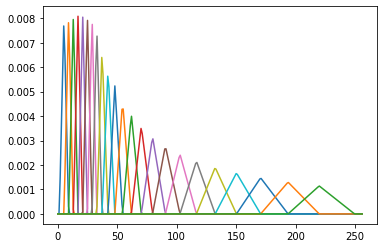

In [263]:
#Mel-filterbank application
mel_filters = np.array(np.load('mel_filters.npy'))
plt.plot(mel_filters.T)
print(mel_filters)
#mel = mel_filters * power[:23, :257]
mel = []
for row in range(len(mel_filters)):
    mel.append(np.sum(mel_filters[row]*power[row][:257]))
mel = np.array(mel)
print(mel)


In [264]:
#taking the log
mellog = np.maximum([-50]*mel.size, np.log(mel))
print (mellog)

[22.77630936 22.21340957 21.65537514 22.47896903 22.61375428 22.42334222
 22.40333963 23.73767906 23.58894415 22.28471521 23.23757787 23.8531977
 23.56358955 23.87578244 23.99521926 24.12396322 32.35038216 34.92789759
 36.09249061 33.84077449 32.19479267 33.06972962 35.02422102]


In [265]:
#Computing the DCT and “liftering”:
c = [[]]
for i in range(mellog.size):
    val = np.sum(np.array(range(mellog.size))*np.cos((np.array(range(mellog.size))+0.5)*(np.pi*i/23)))
    c[0].append(val)
c = np.array(c)
c = c[:, :13]
#c = c[:13]
print(c)

[[ 2.53000000e+02 -1.07114343e+02 -3.55271368e-14 -1.18263012e+01
  -3.55271368e-14 -4.20110725e+00 -4.61852778e-14 -2.09743431e+00
  -7.46069873e-14 -1.22830379e+00  2.84217094e-14 -7.84362773e-01
  -2.30926389e-14]]


[[ 2.53000000e+02]
 [-1.07114343e+02]
 [-3.55271368e-14]
 [-1.18263012e+01]
 [-3.55271368e-14]
 [-4.20110725e+00]
 [-4.61852778e-14]
 [-2.09743431e+00]
 [-7.46069873e-14]
 [-1.22830379e+00]
 [ 2.84217094e-14]
 [-7.84362773e-01]
 [-2.30926389e-14]]
[[2.86121421e+02 8.82833359e+01 1.10734460e+00 ... 3.42458454e+00
  3.82561654e+00 9.07008924e-01]
 [2.86289153e+02 9.24167972e+01 2.91332735e+00 ... 1.68826014e+00
  3.61284937e+00 3.65086968e+00]
 [2.89237676e+02 9.43800202e+01 3.82066903e+00 ... 1.84973034e+00
  6.21173741e+00 3.60466165e+00]
 ...
 [3.00221588e+02 1.03148753e+02 1.15872326e+01 ... 6.99969974e-01
  1.91965287e-02 1.78997048e+00]
 [3.80786166e+02 7.39501850e+01 6.26768414e+00 ... 1.50231180e+00
  3.95700736e-01 1.42263382e+00]
 [3.88720883e+02 7.52602075e+01 4.99451925e+00 ... 8.15009283e-01
  2.13107778e-01 2.26657194e+00]]
15531.734655497135


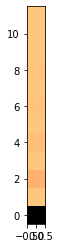

In [266]:
#putting it all together
cdata = np.swapaxes(c, 0, 1)
print(cdata)
plt.imshow(cdata[1:], interpolation='nearest', cmap='copper', origin='lower', aspect='equal')
reference = np.load('reference_mfcc.npy')
diffs = np.absolute(c-reference)
print(diffs)
mse = (np.square(c - reference)).mean()
print(mse)